In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
import time
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [4]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.sample(10)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
242,24/11/2020 14:03:04,29.0,Female,Stuttgart,QA Engineer,6,2,Middle,JS,NaN,54000.0,NaN,26,Full-time employee,Unlimited contract,English,101-1000,Product
1065,02/12/2020 21:53:01,31.0,Male,Berlin,Software Engineer,4,4,Senior,Python,"Python, Javascript / Typescript, AWS, Docker",68000.0,0,30,Full-time employee,Unlimited contract,English,101-1000,Startup
872,27/11/2020 20:17:35,31.0,Male,Munich,ML Engineer,4,4,Senior,Python,Python,100000.0,100000,20,Full-time employee,Unlimited contract,English,1000+,Product
593,25/11/2020 13:58:38,30.0,Male,Berlin,Data Scientist,6,3,Senior,NaN,"Python, SQL, AWS, Google Cloud, Docker",72000.0,85000,27,Full-time employee,Unlimited contract,English,1000+,Startup
1063,02/12/2020 21:39:34,NaN,Male,Munich,Frontend Developer,5,3,Lead,javascript,Javascript / Typescript,70000.0,NaN,24,Full-time employee,Unlimited contract,English,11-50,Startup
727,26/11/2020 05:53:19,22.0,Diverse,Cologne,QA Engineer,1,1,Head,Cobol,Perl,159000.0,35000,45,Full-time employee,Unlimited contract,German,1000+,Product
528,25/11/2020 10:58:00,39.0,Male,Munich,Software Architect,20,12,Lead,embedded,"C/C++, Clojure, Assembly",122000.0,45000,28,Full-time employee,Unlimited contract,English,1000+,Product
817,27/11/2020 09:50:36,26.0,Female,Moscow,Frontend Developer,6,0,Senior,JavaScript,Javascript / Typescript,33000.0,0,NaN,Full-time employee,Unlimited contract,Russian,101-1000,Product
799,26/11/2020 21:42:38,30.0,Female,Düsseldorf,Analyst,2,2,Junior,R,"Python, SQL",45000.0,NaN,28,Full-time employee,Unlimited contract,English,1000+,Product
161,24/11/2020 12:17:32,36.0,Female,Munich,Backend Developer,5,1,Middle,PHP,"Javascript / Typescript, Docker",60000.0,5000,28,Full-time employee,Unlimited contract,English,101-1000,Product


In [6]:
#df.info()
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

In [7]:
df["Bonus"] = pd.to_numeric(df["Yearly bonus + stocks in EUR"], downcast="float", errors="coerce")
df["Bonus"].fillna(0, inplace=True)
df["target"] = df["Yearly brutto salary (without bonus and stocks) in EUR"] + df["Bonus"]
df.drop(columns={"Timestamp","Yearly brutto salary (without bonus and stocks) in EUR", "Yearly bonus + stocks in EUR", "Bonus"}, inplace=True)
df.head()

,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,target
0,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",30,Full-time employee,Unlimited contract,English,51-100,Product,85000.0
1,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product,80000.0
2,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,240000.0
3,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup,54000.0
4,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",29,Full-time employee,Unlimited contract,English,101-1000,Product,62000.0


In [8]:
df_tmp = df[df.groupby("Position ")['Position '].transform('size') > 2 ]
df_tmp = df[df.groupby("Other technologies/programming languages you use often")["Other technologies/programming languages you use often"].transform('size') > 2]
df_tmp = df[df["target"] < 250000]


c:\Users\rod\anaconda3\envs\3450-Clone\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

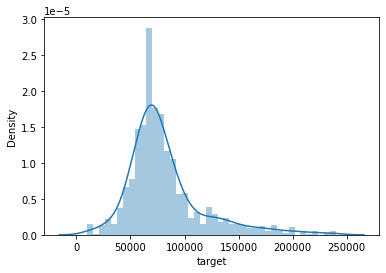

In [9]:
sns.distplot(df_tmp['target'])

In [10]:
df_tmp.count()

Age                                                       1212
Gender                                                    1228
City                                                      1237
Position                                                  1232
Total years of experience                                 1222
Years of experience in Germany                            1207
Seniority level                                           1226
Your main technology / programming language               1113
Other technologies/programming languages you use often    1085
Number of vacation days                                   1172
Employment status                                         1221
Сontract duration                                         1211
Main language at work                                     1222
Company size                                              1221
Company type                                              1214
target                                                 

In [11]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1237 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1212 non-null   float64
 1   Gender                                                  1228 non-null   object 
 2   City                                                    1237 non-null   object 
 3   Position                                                1232 non-null   object 
 4   Total years of experience                               1222 non-null   object 
 5   Years of experience in Germany                          1207 non-null   object 
 6   Seniority level                                         1226 non-null   object 
 7   Your main technology / programming language             1113 non-null   object 
 8   Other technologies/programming languag

In [12]:
def replace_low_freq(d, col, threshold=10, replacement='other'):
    value_counts = d[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

In [13]:
df_tmp["Other technologies/programming languages you use often"] = replace_low_freq(df_tmp, "Other technologies/programming languages you use often", 0, "Other")
df_tmp['Other technologies/programming languages you use often'].value_counts()

C:\Users\rod\AppData\Local\Temp\ipykernel_13476\3436751890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["Other technologies/programming languages you use often"] = replace_low_freq(df_tmp, "Other technologies/programming languages you use often", 0, "Other")


Javascript / Typescript                                           43
Python                                                            36
SQL                                                               31
AWS, Docker                                                       16
Kotlin                                                            15
                                                                  ..
Python, Java / Scala, R, SQL, AWS, Azure                           1
SQL, AWS, Google Cloud, Kubernetes, Docker                         1
Javascript / Typescript, Java / Scala, AWS, Kubernetes, Docker     1
Kotlin, Java / Scala, SQL, Kubernetes, Docker                      1
Python, AWS, Kubernetes, Docker, terraform, ansible                1
Name: Other technologies/programming languages you use often, Length: 557, dtype: int64

In [14]:
df_tmp["Your main technology / programming language"] = replace_low_freq(df_tmp, "Your main technology / programming language", 10, "Other")
df_tmp["Your main technology / programming language"].value_counts()

C:\Users\rod\AppData\Local\Temp\ipykernel_13476\927345426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["Your main technology / programming language"] = replace_low_freq(df_tmp, "Your main technology / programming language", 10, "Other")


Other         371
Java          182
Python        164
PHP            56
C++            36
JavaScript     34
Javascript     31
C#             30
python         26
Scala          24
Go             23
Swift          23
Kotlin         22
Python         20
Ruby           19
SQL            14
TypeScript     13
.NET           13
JS             12
Name: Your main technology / programming language, dtype: int64

In [15]:
df_tmp["Your main technology / programming language"].replace({"Javascript": "JavaScript", "Python ":"Python"}, inplace=True)
df_tmp["Your main technology / programming language"].value_counts()

C:\Users\rod\AppData\Local\Temp\ipykernel_13476\232549923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["Your main technology / programming language"].replace({"Javascript": "JavaScript", "Python ":"Python"}, inplace=True)


Other         371
Python        184
Java          182
JavaScript     65
PHP            56
C++            36
C#             30
python         26
Scala          24
Go             23
Swift          23
Kotlin         22
Ruby           19
SQL            14
TypeScript     13
.NET           13
JS             12
Name: Your main technology / programming language, dtype: int64

In [16]:
df_tmp["City"] = replace_low_freq(df_tmp, "City", 10, "Other")
df_tmp["City"].value_counts()

C:\Users\rod\AppData\Local\Temp\ipykernel_13476\1394189939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["City"] = replace_low_freq(df_tmp, "City", 10, "Other")


Berlin       671
Munich       234
Other        203
Frankfurt     44
Hamburg       40
Stuttgart     26
Cologne       19
Name: City, dtype: int64

In [17]:
#This function allows to change the comma
#gets 2 arguments, the df and the column name

def replace_comma(df, column_name):
    for i, row in df.iterrows():
        value = row[column_name]
        if isinstance(value, str):
            df.at[i, column_name] = value.replace(',','.')
        else:
            df.at[i, column_name] = value

Some of the numbers are separated by comma to denote a floating point number, i.e. 1,5 years instead of 1.5. To replace them, I used the function above.

In [18]:
replace_comma(df_tmp, 'Total years of experience')
replace_comma(df_tmp, 'Years of experience in Germany')
replace_comma(df_tmp, 'Number of vacation days')

I replaced some values manually. Some of them are long text and only used the numeric values.

In [ ]:
df_tmp['Total years of experience'].replace(to_replace= ['1 (as QA Engineer) / 11 in total'], value= 11, inplace=True)
df_tmp['Total years of experience'].replace(to_replace= ['15. thereof 8 as CTO'], value= 15, inplace=True)
df_tmp['Total years of experience'].replace(to_replace= ['6 (not as a data scientist. but as a lab scientist)'], value= 6, inplace=True)
df_tmp['Total years of experience'].replace(to_replace= ['less than year'], value= 1, inplace=True)
#df['Column1'].replace(to_replace=[1, 5], value=1.5, inplace=True)

In [ ]:
df_tmp['Years of experience in Germany'].replace(to_replace= ['< 1', '4 month', '3 months','<1', 'less than year', ], value= 1, inplace=True)
df_tmp['Years of experience in Germany'].replace(to_replace= ['4 (in Switzerland). 0 (in Germany)', '3 (in Poland)', '⁰', '-'], value= 0, inplace=True)
df_tmp['Years of experience in Germany'].replace(to_replace= ['6 (not as a data scientist. but as a lab scientist)'], value= 6, inplace=True)

In [ ]:
df_tmp['Number of vacation days'].replace(to_replace= ['unlimited', 'unlimited ','30 in contract (but theoretically unlimited)', 'Unlimited ', 'Unlimited'], value= 15, inplace=True) # will replace to the max value
df_tmp['Number of vacation days'].replace(to_replace= ['(no idea)'], value= 10, inplace=True) # will replace to mode value later
df_tmp['Number of vacation days'].replace(to_replace= ['~25'], value= 25, inplace=True)
df_tmp['Number of vacation days'].replace(to_replace= ['23+'], value= 23, inplace=True)
df_tmp['Number of vacation days'].replace(to_replace= ['24 labour days'], value= 24, inplace=True)

In [ ]:
df_tmp['Total years of experience'] = df_tmp['Total years of experience'].astype('float64')
df_tmp['Years of experience in Germany'] = df_tmp['Years of experience in Germany'].astype('float64')
df_tmp['Number of vacation days'] = df_tmp['Number of vacation days'].astype('float64')

In [ ]:
df_tmp['Number of vacation days'].replace(to_replace= ['unlimited', 'unlimited ','30 in contract (but theoretically unlimited)', 'Unlimited ', 'Unlimited'], value= df_tmp['Number of vacation days'].quantile(0.75), inplace=True) # will replace to the max value
df_tmp['Number of vacation days'].replace(to_replace= ['(no idea)'], value= df_tmp['Number of vacation days'].mode(), inplace=True) # will replace to mode value later

In [24]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1237 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1212 non-null   float64
 1   Gender                                                  1228 non-null   object 
 2   City                                                    1237 non-null   object 
 3   Position                                                1232 non-null   object 
 4   Total years of experience                               1222 non-null   float64
 5   Years of experience in Germany                          1207 non-null   float64
 6   Seniority level                                         1226 non-null   object 
 7   Your main technology / programming language             1113 non-null   object 
 8   Other technologies/programming languag

c:\Users\rod\anaconda3\envs\3450-Clone\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Years of experience in Germany', ylabel='count'>

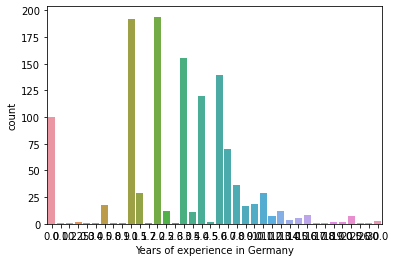

In [25]:
sns.countplot(df_tmp['Years of experience in Germany'])

c:\Users\rod\anaconda3\envs\3450-Clone\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total years of experience', ylabel='Density'>

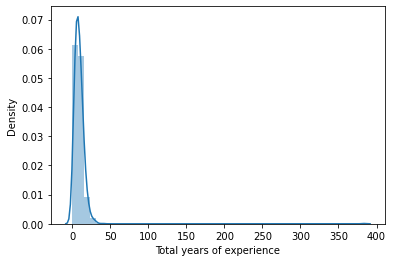

In [26]:
sns.distplot(df_tmp['Total years of experience'])

In [27]:
df_tmp['Total years of experience'].describe()

count    1222.000000
mean        9.029951
std        11.928410
min         0.000000
25%         5.000000
50%         8.000000
75%        12.000000
max       383.000000
Name: Total years of experience, dtype: float64

In [28]:
df_tmp = df_tmp[df_tmp['Total years of experience'] < 50]

c:\Users\rod\anaconda3\envs\3450-Clone\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Years of experience in Germany', ylabel='Density'>

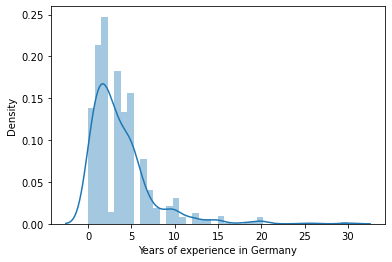

In [30]:
sns.distplot(df_tmp['Years of experience in Germany'])

In [31]:
df_tmp.describe()

,Age,Total years of experience,Years of experience in Germany,Number of vacation days,target
count,1203.000000,1221.000000,1196.000000,1163.000000,1221.000000
mean,32.423109,8.723669,3.676839,28.194755,81661.707273
std,5.540926,5.260761,3.554786,10.621283,35713.860262
min,20.000000,0.000000,0.000000,0.000000,10001.000000
25%,29.000000,5.000000,1.000000,27.000000,60000.000000
50%,32.000000,8.000000,3.000000,28.000000,73000.000000
75%,35.000000,12.000000,5.000000,30.000000,90000.000000
max,66.000000,40.000000,30.000000,365.000000,240000.000000


In [32]:
df_tmp = df_tmp[df_tmp['Number of vacation days'] < 50]

In [33]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1144 non-null   float64
 1   Gender                                                  1155 non-null   object 
 2   City                                                    1160 non-null   object 
 3   Position                                                1158 non-null   object 
 4   Total years of experience                               1160 non-null   float64
 5   Years of experience in Germany                          1137 non-null   float64
 6   Seniority level                                         1154 non-null   object 
 7   Your main technology / programming language             1059 non-null   object 
 8   Other technologies/programming languag

c:\Users\rod\anaconda3\envs\3450-Clone\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

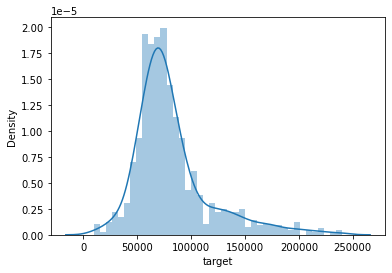

In [34]:
sns.distplot(df_tmp['target'])

In [36]:
numeric_features = ["Age", "Total years of experience", "Years of experience in Germany", "Number of vacation days"]
categorical_features = ["Gender", "City", "Position ", "Seniority level", "Your main technology / programming language", "Other technologies/programming languages you use often", 
                        "Employment status", "Сontract duration", "Main language at work", "Company size", "Company type"]

In [37]:
for col in numeric_features:
    df_tmp[col]=df_tmp[col].astype(float)
for col in categorical_features:
    df_tmp[col]=df_tmp[col].astype("category")

Data Imputation and Column Transformation

In [39]:

numeric_transformer = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer( transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ])

#Split data as normal
y = df_tmp["target"]
x = df_tmp.drop(columns={"target"})

#Build pipeline
l1_model = Lasso()
l2_model = Ridge()
pipeline_steps = [('pre', preprocessor),('model', l2_model) ]
pipe = Pipeline(pipeline_steps)

X_train, X_test, y_train, y_test = train_test_split(x, y)
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set

pipe.fit(X_train, y_train)
cvs = cross_val_score(pipe, X_train, y_train.ravel(), cv=5)
y_pred = pipe.predict(X_test)
print('Training CrossVal Score:', cvs)
print("Average Train Score:", np.mean(cvs))
print('Testing score:', pipe.score(X_test, y_test))
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2:", r2_score(y_test, y_pred))

Training CrossVal Score: [0.1737445  0.22370835 0.0066556  0.01244536 0.23303798]
Average Train Score: 0.1299183558959681
Testing score: 0.18767039047031753
RMSE: 31700.35
R2: 0.18767039047031753


Elastic Net Regressor

In [40]:
from sklearn.linear_model import ElasticNet
#Prep pipeline and model with grid
el_model = ElasticNet(max_iter=20000)
pipeline_steps = [('pre', preprocessor),('model', el_model) ]
pipe3 = Pipeline(pipeline_steps)
params = {'model__l1_ratio':[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]}
 
est = GridSearchCV(pipe3, param_grid=params, cv=5, n_jobs=-1) 
est.fit(X_train, y_train.ravel())
best = est.best_estimator_
y_pred = best.predict(X_test)
print(best.score(X_test, y_test.ravel()))
print(best)
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2:", r2_score(y_test, y_pred))

0.21099560571010023
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Total years of experience',
                                                   'Years of experience in '
                                                   'Germany',
                                                   'Number of vacation days']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'City'

SGD Regressor

In [64]:
#SGD Regressor. 
pipe_SGD_steps = [('pre', preprocessor), ('scale', MaxAbsScaler()), ('model', SGDRegressor(max_iter=10000, eta0=.1))]
pipe_SGD = Pipeline(pipe_SGD_steps)

start = time.process_time()
pipe_SGD.fit(X_train, y_train.ravel())
print(time.process_time() - start)

#Print best model and test score
print('Training CrossVal Score:', cross_val_score(pipe_SGD, X_train, y_train.ravel(), cv=5))
print('Testing score:', pipe_SGD.score(X_test, y_test))
y_pred = pipe_SGD.predict(X_test)
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

0.046875
Training CrossVal Score: [ 0.12393751  0.17918628 -0.04654243 -0.03537358  0.20073624]
Testing score: 0.16393490267683175
RMSE: 32160.15


Random Forest Regressor

In [61]:
# Build the pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_jobs=-1, n_estimators=300))
])
# Fit the pipeline to the training data

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Evaluate the pipeline on the training and testing data
print("Training Accuracy:", pipeline.score(X_train, y_train))
print("Training RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))))
print("Testing Accuracy:", r2_score(y_test, y_pred))
print("Testing RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

Training Accuracy: 0.892502615323118
Training RMSE: 11723.99
Testing Accuracy: 0.2912460383673896
Testing RMSE: 29610.50


Parameter tuning with Gridsearch CV

In [47]:
estimator_ = RandomForestRegressor(n_jobs=-1)
pipe_ = Pipeline(steps=[("preprocessor", preprocessor), ("forest", estimator_)])

params_ = {'forest__max_depth':[5, 7, 9, 11, 13, 15], 
            "forest__n_estimators":[100, 200, 300, 400, 500],
            "forest__max_features":[20, 30, 40, 50, 60, 70, 80, 90]}
 
clf_ = GridSearchCV(pipe_, param_grid=params_, cv=5, n_jobs=-1) 
clf_.fit(X_train, y_train.ravel())
best_ = clf_.best_estimator_
print(best_.score(X_test, y_test))
print(best_)

0.28677642609251197
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Total years of experience',
                                                   'Years of experience in '
                                                   'Germany',
                                                   'Number of vacation days']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender

Using the generated best model after Gridsearch CV.

In [53]:
model =  RandomForestRegressor(max_depth=15, max_features=80,
                                       n_estimators=300, n_jobs=-1)

pipeline_steps = [('pre', preprocessor),('model', model) ]
pipe = Pipeline(pipeline_steps)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print('Testing score:', pipe.score(X_test, y_test))
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

Testing score: 0.28714170340225753
RMSE: 29696.11
R2: 0.28714170340225753


Getting the optimal number of features using RFECV

In [ ]:
#Add a pipeline
model =  RandomForestClassifier(n_jobs=-1)
pipe_model = LogisticRegression(max_iter=1000, solver="saga")
rfecv = RFECV(
    estimator=pipe_model,
    step=1,
    cv=3,
    scoring="r2",
    min_features_to_select=10
)


pipeline_steps = [('pre', preprocessor), ("fs", rfecv), ('model', model)]
pipe = Pipeline(pipeline_steps)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print('Testing score:', pipe.score(X_test, y_test))
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("Optimal number of features : %d" % rfecv.n_features_)

# Answers and Explanations
The data needed a lot of cleaning before building a model. Some of the things I did were:
    <li> Filter outliers
    <li> Replaced some values
    <li> Transformed columns and imputed data to handle missing values

### Results
I tried building the following models:
    <li> Lasso, Ridge and ElasticNet Regressors, which really did not give good results.
    <li> SGD Regressor was also not great.
    <li> Finally, a RandomForest Regressor which gave a promising training R2 score of 0.89. A training RMSE was 11723.99 and the model did fair I would say.
         But the model did not generate a good R2 and RMSE when tested on the testing dataset. The model maybe overfitted and needed some more tuning. Or perhaps more data preparation and cleaning.

### Feature Selection Activities
I tried using RFECV to get the optimal number of features for the model. The code seemed to be working but it was taking a while to produce the output. In the end, I did not wait and was not able to get the results. =( 

### Hyperparameter Changes
Since the RandomForest gave the best results among the models I tried, I tried Gridsearch CV to look for the best parameters to tune the model. I looked for the best number of tree depth, number of estimators and number of features. After getting the best parameters, the testing R2 and RMSE did not change much. 